In [234]:
from fipy import Variable, FaceVariable, CellVariable, Grid1D, \
NthOrderBoundaryCondition, ExplicitDiffusionTerm, TransientTerm, DiffusionTerm, Viewer,PowerLawConvectionTerm,ImplicitSourceTerm
from fipy.tools import numerix
from fipy import DefaultSolver
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
font = {'size'   : 16}
matplotlib.rc('font', **font)

In [235]:
L = 3.
T = 1.
nx = 1000
nt = 1000
dx = L/nx
mesh = Grid1D(nx=nx, dx=dx)
D = 1.
P=1.
valueLeft = 1
valueRight = 0
timeStepDuration = T/nt
steps = nt
x = mesh.cellCenters[0]
a = 2
initialArray = numerix.sin(np.pi*x/L)

In [236]:
phi = CellVariable(name="solution variable",
                   mesh=mesh,
                   value=initialArray)


phi.constrain(0,where=mesh.facesLeft)
phi.constrain(0, where= mesh.facesRight)


eqX = (TransientTerm(coeff = 1)
      == DiffusionTerm(coeff=a) )

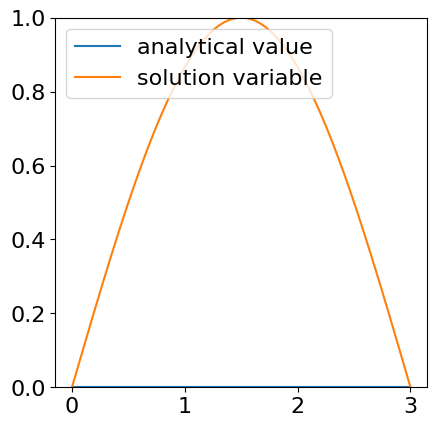

In [237]:
phiAnalytical = CellVariable(name="analytical value",
                             mesh=mesh)

if __name__ == '__main__':
    viewer = Viewer(vars=(phiAnalytical, phi),
                    datamin=0., datamax=1.)
   

In [238]:
from scipy.integrate import quad

# Параметры задачи
         # Длина стержня
alpha = a     # Коэффициент температуропроводности
T_final = T   # Конечное время

# Создаем сетку (x, t)
Nx = nx        # Число точек по пространству
Nt = nt          # Число точек по времени
x = np.linspace(0, L, Nx)
t = np.linspace(0, T_final, Nt)
XX, TT = np.meshgrid(x, t)  # Формируем сетку для векторных вычислений

# Начальное условие (можно изменить на любую функцию)
def initial_condition(x):
    return np.sin(np.pi * x / L)  # Простое начальное условие
    # return x * (L - x)         # Другой вариант (раскомментировать для использования)

# Вычисляем коэффициенты Фурье B_n для начального условия
def fourier_coeff(n, L):
    def integrand(x):
        return initial_condition(x) * np.sin(n * np.pi * x / L)
    Bn, _ = quad(integrand, 0, L)
    return (2 / L) * Bn

# Точное решение (учитывает первые N_terms членов ряда Фурье)
def exact_solution(x, t, N_terms=20):
    u = np.zeros_like(x)
    for n in range(1, N_terms + 1):
        Bn = fourier_coeff(n, L)
        u += Bn * np.sin(n * np.pi * x / L) * np.exp(-alpha * (n * np.pi / L)**2 * t)
    return u

# Векторизуем функцию для работы с сеткой
U_exact = np.zeros_like(XX)
for i in range(Nt):
    U_exact[i, :] = exact_solution(XX[i, :], TT[i, :])



In [239]:
import deepxde as dde
import numpy as np
dde.backend.set_default_backend("pytorch")
import matplotlib.pyplot as plt
import torch
import math

geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, T)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)
def pc(u):
    return torch.full_like(u,1)
def K_(u):
    return torch.full_like(u,1)*a
def pde(x, u):
    du_t = dde.grad.jacobian(u, x, i=0, j=1)  # производная по времени
    du_xx = dde.grad.hessian(u, x, i=0, j=0)  # вторая производная по x
    K = K_(u)
    du_x = dde.grad.jacobian(u,x,i=0,j=0)
    #dK_u = dde.grad.jacobian(K,u, i = 0, j = 0)
    
    return du_t - (K * du_xx) #+ dK_u*(du_x)**2)/pc(u)

def boundary_left(x, on_boundary):
    
    return on_boundary and np.isclose(x[0], 0) and not np.isclose(x[1],0)
def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], L) and not np.isclose(x[1],0)

def boundary_left_0(x, on_boundary):
    
    return on_boundary and np.isclose(x[0], 0) and np.isclose(x[1],0)
def boundary_right_0(x, on_boundary):
    return on_boundary and np.isclose(x[0], L) and np.isclose(x[1],0)

def right_condition(x, u, _):
    grad = dde.grad.jacobian(u, x, i = 0, j = 0)

    return u
def left_condition(x,u,_):
    grad = dde.grad.jacobian(u, x, i = 0, j = 0)

    return u
def initial_condition(x):
    return np.sin(np.pi*x[:,0:1]/L)
bc_right = dde.OperatorBC(geomtime, right_condition, boundary_right)
bc_left = dde.OperatorBC(geomtime, left_condition, boundary_left)

ic = dde.IC(
    geomtime,
    initial_condition,
    lambda _, on_initial: on_initial,
)

# Сборка задачи
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_left, bc_right,ic],
    num_domain=2000,  # точек внутри области
    num_boundary=200, # точек на границе
    num_initial=200,  # точек для начального условия
    
)
net = dde.nn.FNN(
                    [2] + [120] * 1 + [1],  # 2 входа (x,t), 4 слоя по 32 нейрона, 1 выход
                    "tanh",
                    "Glorot normal",
                )
model = dde.Model(data, net)
resampler = dde.callbacks.PDEPointResampler(period=100)  # Пересчет точек каждые 100 эпох
      
model.compile("adam", lr=1e-3, loss=torch.nn.MSELoss(reduction='sum'), loss_weights=[1,1,1,1])
model.train(iterations=4000,callbacks=[resampler] )
model.compile('L-BFGS', loss = torch.nn.MSELoss(reduction='sum'), loss_weights= [1,1,1,1])
losshistory, train_state = model.train()


Setting the default backend to "pytorch". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Compiling model...
'compile' took 0.000628 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [8.02e-01, 8.67e-02, 4.18e+00, 1.40e+02]    [8.02e-01, 8.67e-02, 4.18e+00, 1.40e+02]    []  
1000      [4.74e-01, 8.52e-01, 2.13e+00, 3.37e+00]    [4.76e-01, 8.52e-01, 2.13e+00, 3.37e+00]    []  
2000      [5.74e-01, 1.44e-01, 8.67e-01, 9.65e-01]    [5.75e-01, 1.44e-01, 8.67e-01, 9.65e-01]    []  
3000      [3.14e-01, 2.11e-01, 4.36e-01, 5.24e-01]    [3.10e-01, 2.11e-01, 4.36e-01, 5.24e-01]    []  
4000      [2.00e-01, 2.16e-01, 2.50e-01, 3.42e-01]    [1.97e-01, 2.16e-01, 2.50e-01, 3.42e-01]    []  

Best model at step 4000:
  train loss: 1.01e+00
  test loss: 1.01e+00
  test

Saving loss history to /home/ivan/MEPHI/nauchka/classicThermo/loss.dat ...
Saving training data to /home/ivan/MEPHI/nauchka/classicThermo/train.dat ...
Saving test data to /home/ivan/MEPHI/nauchka/classicThermo/test.dat ...


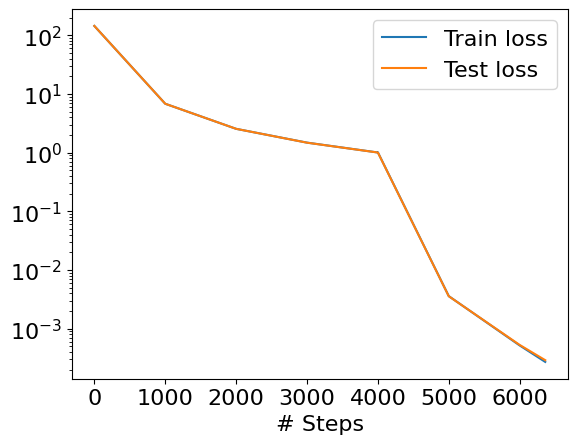

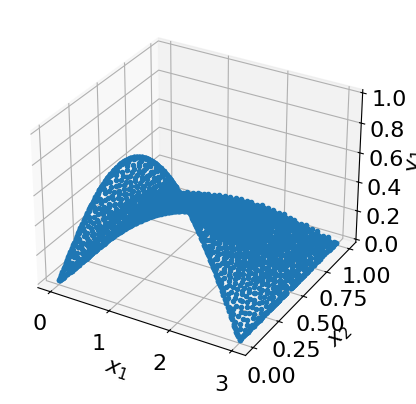

In [240]:
dde.saveplot(losshistory,train_state)

In [241]:


from builtins import range
solver = DefaultSolver()
phiArr = []
pinnArr = []
phiDiffArr= []
pinnDiffArr = []
phiAnalytical.setValue(U_exact[0])
for step in range(steps):
    phiArr.append(np.array(phi))
    phiDiffArr.append((phiArr[-1] - U_exact[step]))
    pinnArr.append(model.predict(torch.Tensor([XX[step], TT[step]]).T).ravel())
    pinnDiffArr.append((pinnArr[-1] - U_exact[step]))
    phiAnalytical.setValue(U_exact[step])
    eqX.solve(var=phi,
              dt=timeStepDuration,
              #boundaryConditions = BCs,
              solver = solver)
    #viewer.plot()
    

In [242]:

print(np.mean((np.mean(np.pow(phiDiffArr,2),axis=1))))
print(np.max(np.abs(phiDiffArr)))
print(np.mean((np.mean(np.pow(pinnDiffArr,2),axis=1))))
print(np.max(np.abs(pinnDiffArr)))


4.6468631433294026e-07
0.001570795680831225
5.369132004803012e-08
0.0011107921600341797


Text(0.5, 0.5, 't')

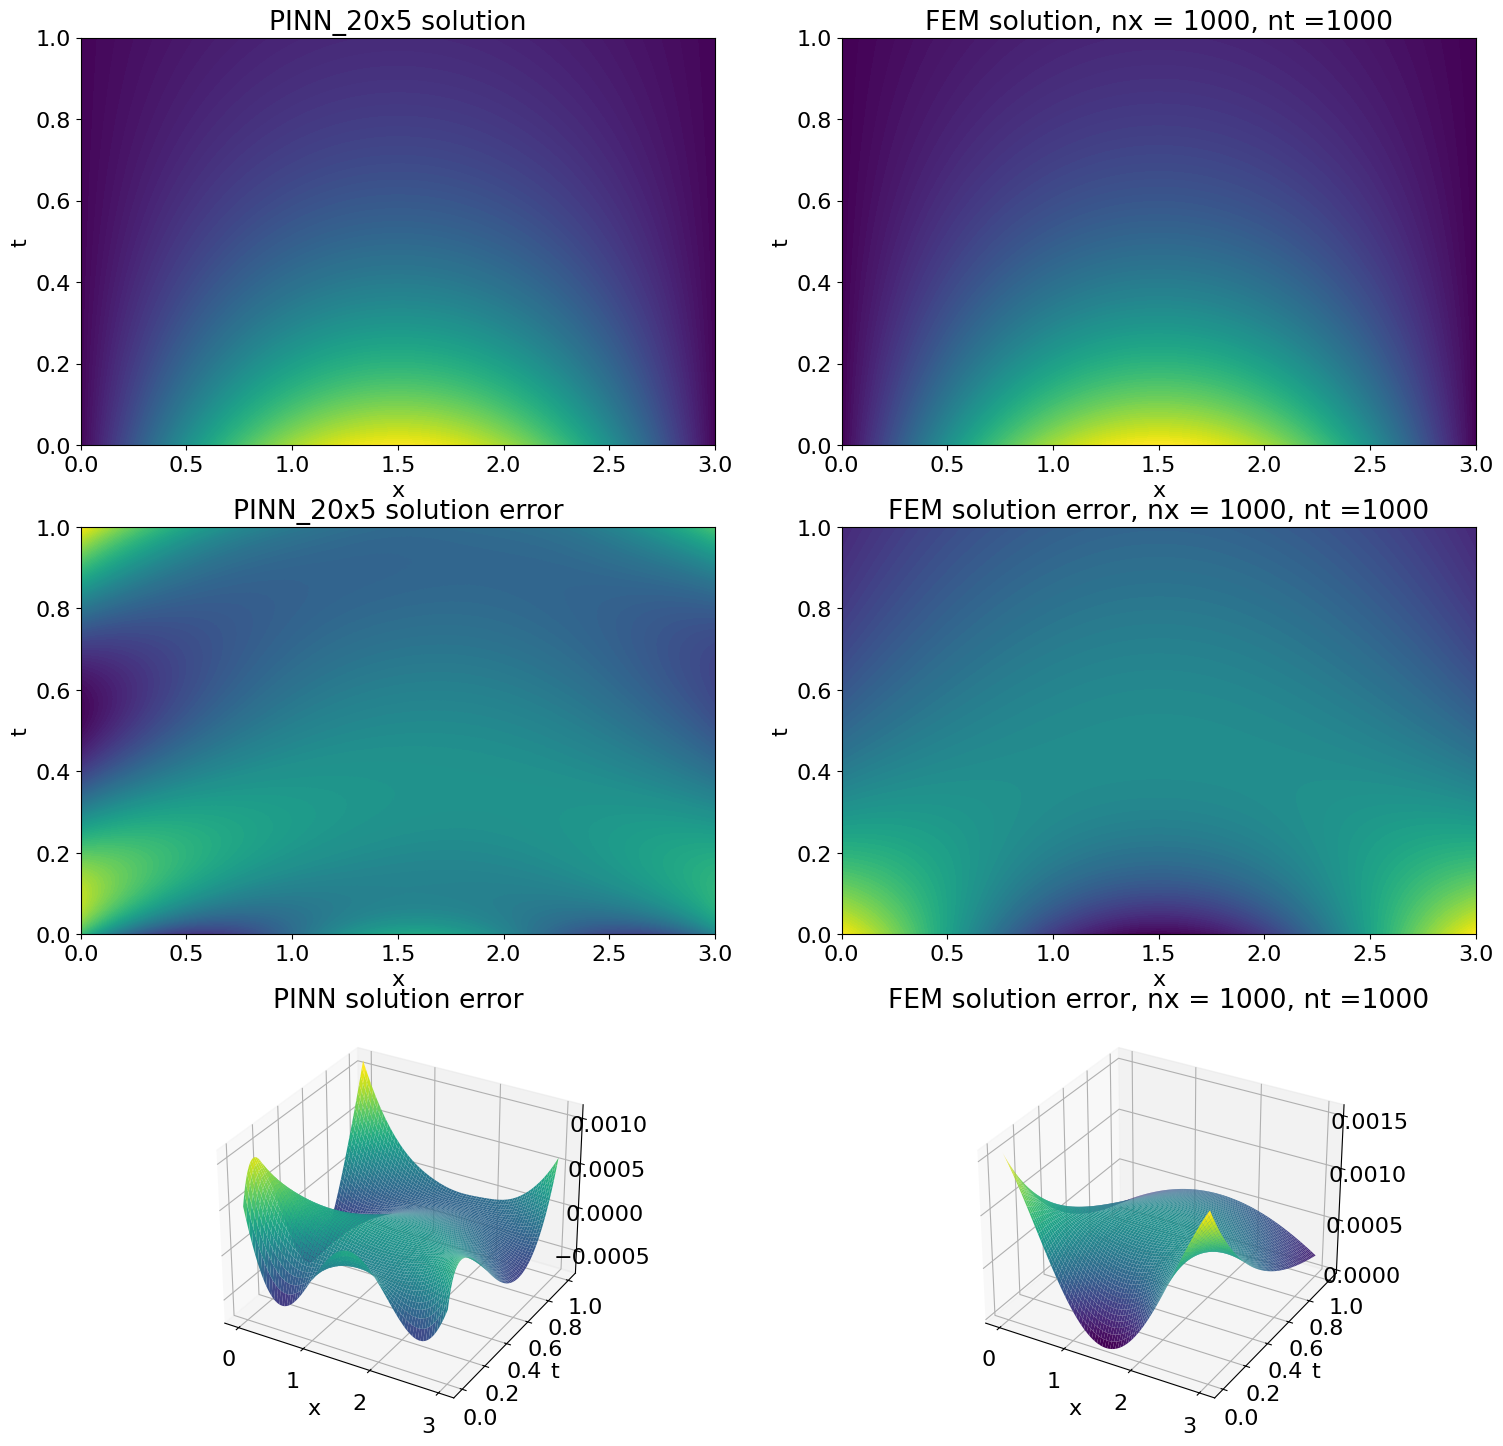

In [244]:
fig = plt.figure(figsize= (18,18))
ax = fig.add_subplot(3,2,1)
ax.contourf(XX,TT,pinnArr, levels=100)
ax.set_title('PINN_20x5 solution')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax = fig.add_subplot(3,2,2)
ax.contourf(XX,TT,phiArr, levels=100)
ax.set_title(f'FEM solution, nx = {nx}, nt ={nt}')
ax.set_xlabel('x')
ax.set_ylabel('t')

ax = fig.add_subplot(3,2,3)
ax.contourf(XX,TT,pinnDiffArr, levels=100)
ax.set_title('PINN_20x5 solution error')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax = fig.add_subplot(3,2,4)
ax.contourf(XX,TT,phiDiffArr, levels=100)
ax.set_title(f'FEM solution error, nx = {nx}, nt ={nt}')
ax.set_xlabel('x')
ax.set_ylabel('t')


ax = fig.add_subplot(3,2,5, projection = '3d')
ax.plot_surface(XX,TT,np.array(pinnDiffArr),rcount=80, ccount=80, cmap="viridis", edgecolor="none")
ax.set_title('PINN solution error')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax = fig.add_subplot(3,2,6, projection = '3d')
ax.plot_surface(XX,TT,np.array(phiDiffArr),rcount=80, ccount=80, cmap="viridis", edgecolor="none")
ax.set_title(f'FEM solution error, nx = {nx}, nt ={nt}')
ax.set_xlabel('x')
ax.set_ylabel('t')


